In [1]:
# Data stuff
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

# Dask
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

# Prepa data-set for models

In [2]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_missing_entire/*.part')
# Ensure correct types
dataset = dataset.astype(dtype={
    'gender':int,
    'ethnicity_AMERICAN INDIAN/ALASKA NATIVE':int,
    'ethnicity_ASIAN':int,
    'ethnicity_BLACK/AFRICAN AMERICAN':int,
    'ethnicity_HISPANIC/LATINO':int,
    'ethnicity_WHITE':int,
    'insurance_Medicaid':int,
    'insurance_Medicare':int,
    'marital_status_DIVORCED':int,
    'marital_status_MARRIED':int,
    'marital_status_SINGLE':int,
    'marital_status_WIDOWED':int,
    'language_english':int,
    'hospital_expire_flag':int,
})
# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

In [3]:
# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values

# dataset as is, but target variable dropped(hospital expire flag)
dataset_no_target = dataset.drop(columns=['hospital_expire_flag'])

# Feture names and categorical feature names
feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() + dataset_no_target.select_dtypes(exclude='int').columns.values.tolist() 
cat_feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() 

# Generate data set with categories(int type required)
dataframe_int_list = dataset_no_target.select_dtypes(include='int').values.tolist()
dataframe_no_int_list = dataset_no_target.select_dtypes(exclude='int').values.tolist()
Y = dataset.hospital_expire_flag.values.tolist()
X = []
for i,v in enumerate(dataframe_int_list):
    X = X + [v+dataframe_no_int_list[i]]

# Generate categorical feature indicies
cat_features_indices=list(range(0,len(dataframe_int_list[0])))

# Define functions and variables

In [4]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    folds = 3
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = rand_state)
    
    # Perform fit and scoring
    if uses_cat:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X, Y),random_state = rand_state, refit=True, verbose=3,  )
        random_search.fit(X, Y)     
    else:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
        random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

# Scale of negative class to the positive class(#survived/#died)
scale_pos_weight_min = int( (dataset[dataset.hospital_expire_flag==0].shape[0] / dataset[dataset.hospital_expire_flag==1].shape[0]) )

# Models

## XGBOOST

In [5]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = {
        'learning_rate': (0.01, 0.05,0.1),
        'min_child_weight': [3, 5, 10],
        'gamma': [0.5, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': list(range(5,30)),
        'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  5.5min finished


0.8556147046932824

{'subsample': 0.8,
 'scale_pos_weight': 21,
 'min_child_weight': 10,
 'max_depth': 25,
 'learning_rate': 0.05,
 'gamma': 0.5,
 'colsample_bytree': 1.0}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       14.213975      0.220180         0.087765        0.005085   
1        6.601673      0.504670         0.099068        0.004485   
2        4.608339      0.048425         0.087100        0.002618   
3       13.258864      0.193870         0.103391        0.000470   
4       11.140530      0.038423         0.095744        0.000814   
5        9.023527      0.135887         0.074135        0.004179   
6        9.939410      0.128629         0.083776        0.002155   
7        8.185768      0.131920         0.108377        0.008631   
8        8.308108      0.721798         0.123669        0.006463   
9        9.363617      0.505535         0.114029        0.004017   
10      10.728633      0.129455         0.104387        0.003291   
11      11.023178      0.145716         0.093084        0.002049   
12       6.334055      0.044832         0.104720        0.002155   
13       9.152183      0.078032         0.099734        0.007463   
14       8.943409      0.304191         0.104719        0.014315   
15       5.671162      0.295813         0.064162        0.000940   
16       7.158184      0.042316         0.097074        0.006165   
17      10.584352      0.131558         0.123669        0.011996   
18       8.214691      0.535835         0.116023        0.009715   
19       7.124940      0.542117         0.085106        0.000941   
20       8.421804      0.087736         0.102060        0.011866   
21       2.386283      0.021504         0.034574        0.000941   
22       4.938455      0.028691         0.095411        0.005720   
23       9.137888      0.118231         0.103058        0.003761   
24       9.136226      0.087179         0.106050        0.000470   
25       2.389275      0.022922         0.035571        0.000470   
26      11.339997      0.131025         0.086768        0.006463   
27      11.478958      0.398825         0.139627        0.015472   
28       7.304127      0.105552         0.102399        0.003079   
29      12.106280      0.117799         0.105717        0.002936   
30       5.485991      0.115364         0.069148        0.002859   
31       3.952427      0.093954         0.067818        0.002154   
32      10.141536      0.070683         0.135638        0.024847   
33      10.791796      0.196918         0.101396        0.008157   
34       9.916804      0.344585         0.133975        0.023095   
35      10.952699      0.124014         0.110039        0.006112   
36      10.317399      0.050488         0.095079        0.002860   
37      11.962000      0.103428         0.102393        0.005422   
38      11.413135      0.083872         0.101395        0.001244   
39       3.587735      0.183829         0.074135        0.000940   
40       8.746601      0.062808         0.100065        0.005299   
41       2.790535      0.056471         0.045212        0.002351   
42       2.706760      0.084877         0.065158        0.002618   
43       9.281836      0.086584         0.148602        0.007768   
44      10.729298      0.117975         0.100730        0.003549   
45       8.021208      0.105171         0.101728        0.003550   
46       7.218356      0.037364         0.092752        0.001410   
47       8.073735      0.053251         0.092419        0.002487   
48       8.561429      0.389346         0.116356        0.012987   
49       6.495962      0.468427         0.066156        0.005543   

   param_subsample param_scale_pos_weight param_min_child_weight  \
0                1                     20                     10   
1              0.6                      9                     10   
2                1                     22                     10   
3                1                     12                      3   
4              0.6                     22                      5   
5                1                     15                      5   
6              0.6                     12                  

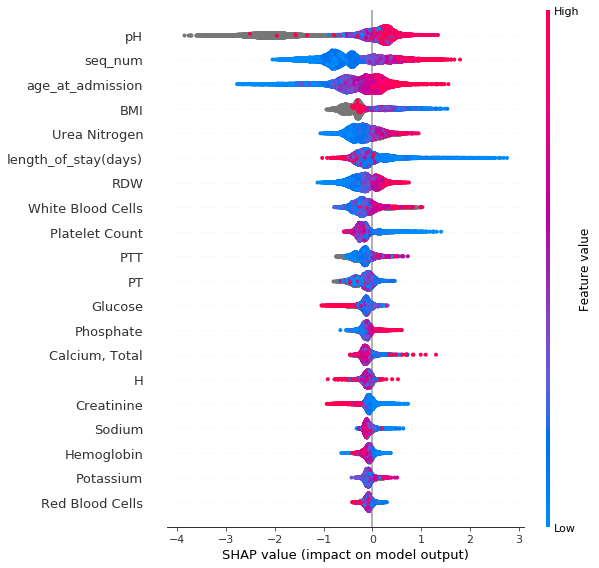

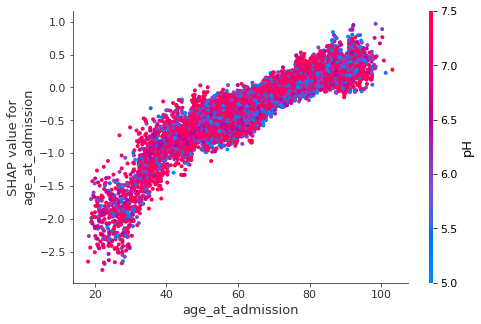

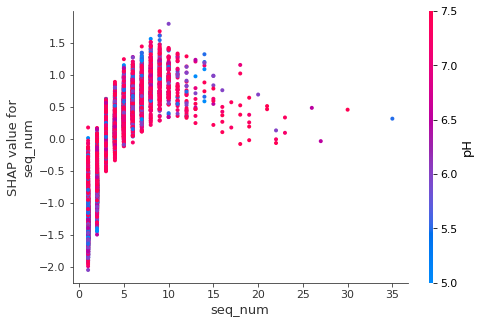

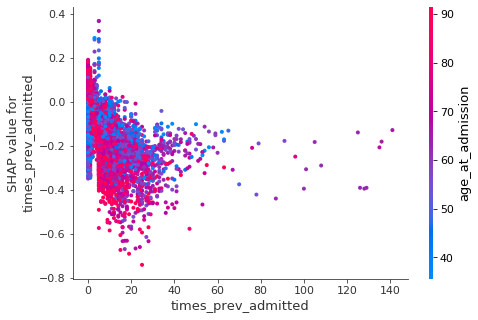

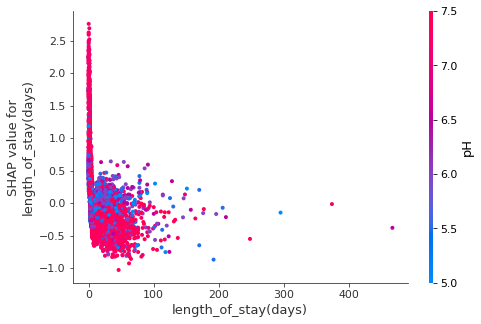

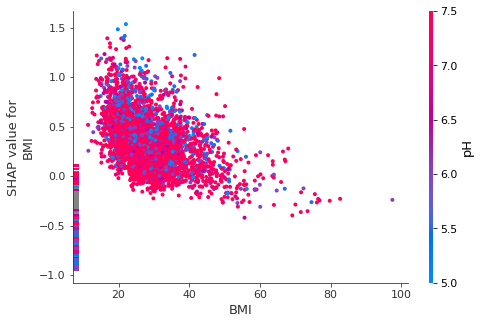

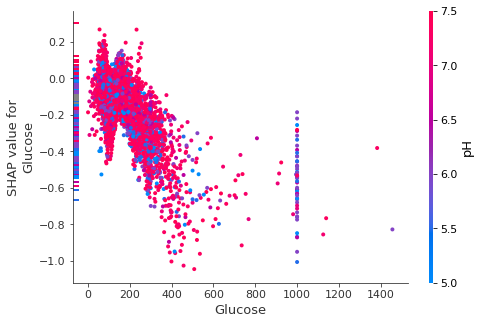

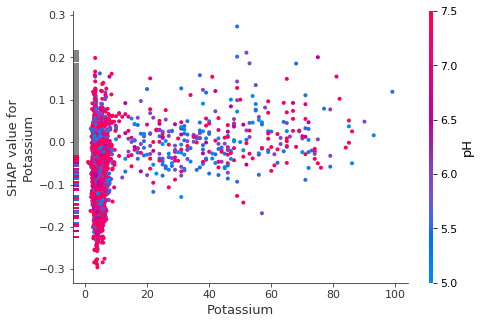

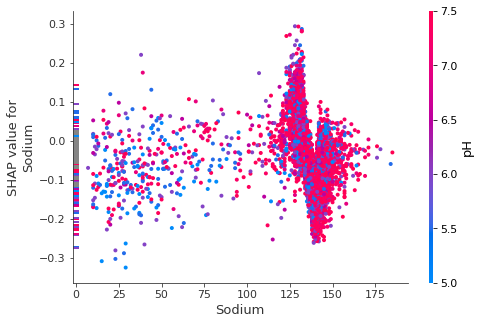

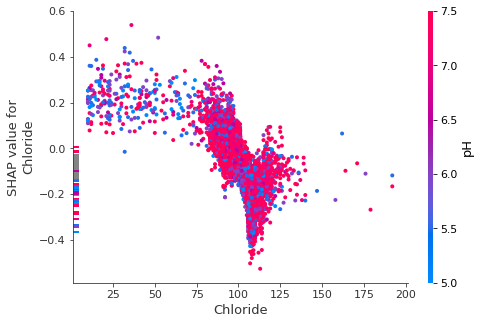

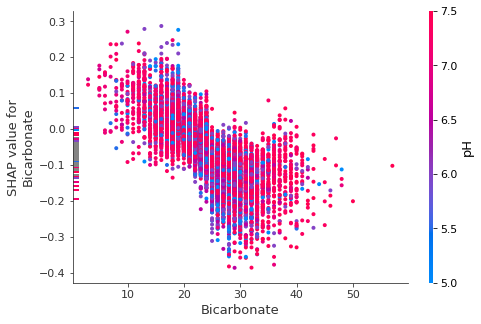

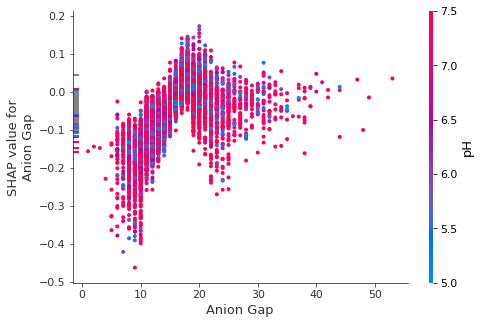

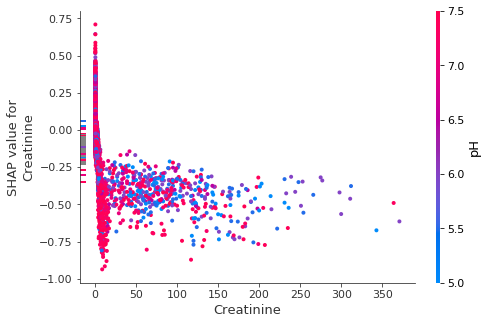

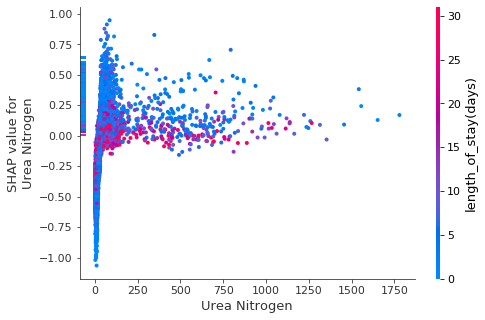

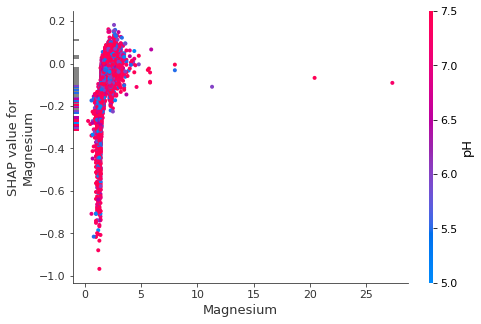

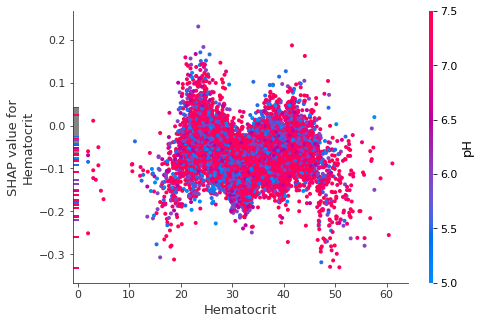

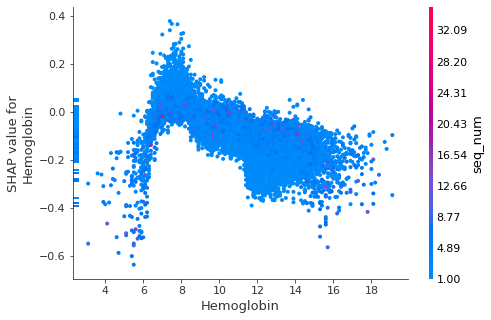

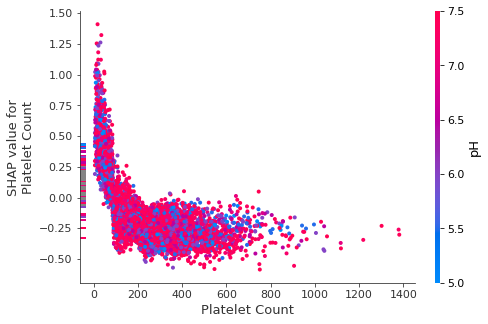

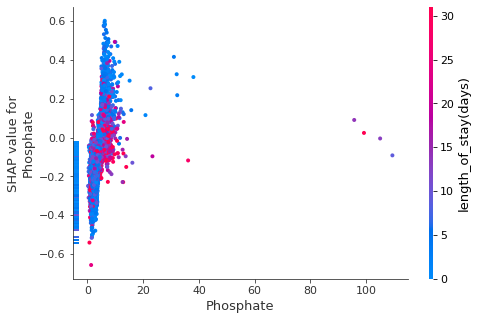

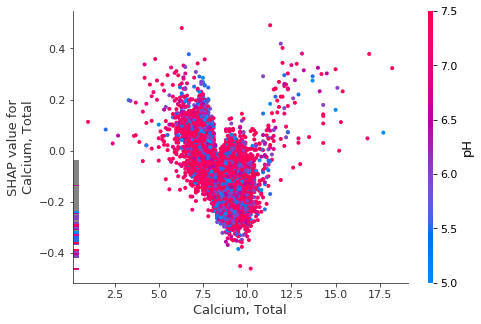

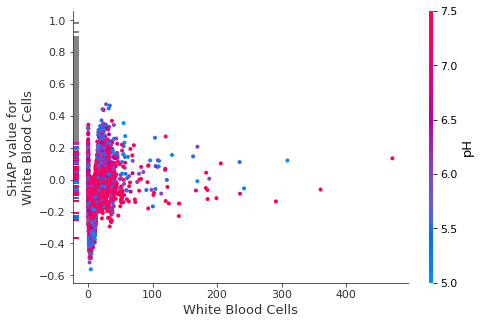

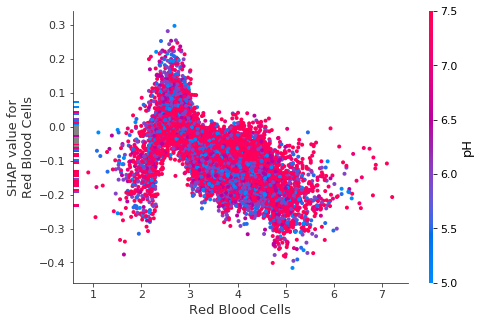

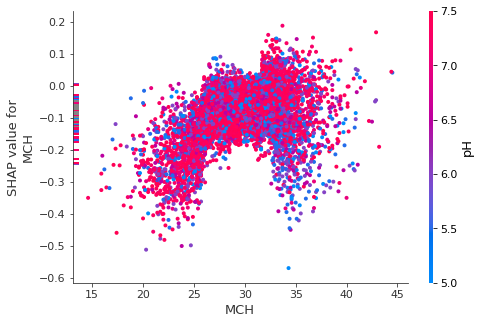

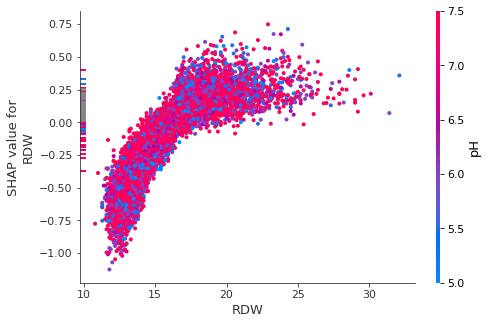

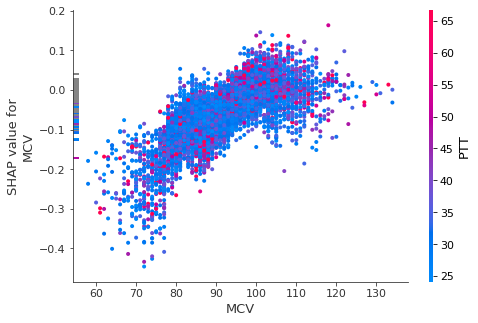

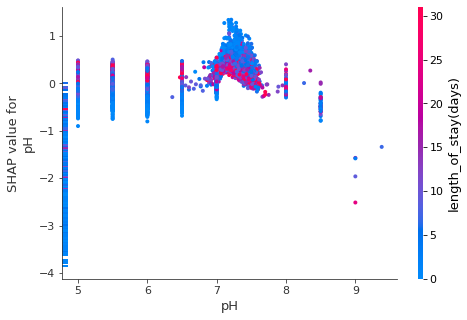

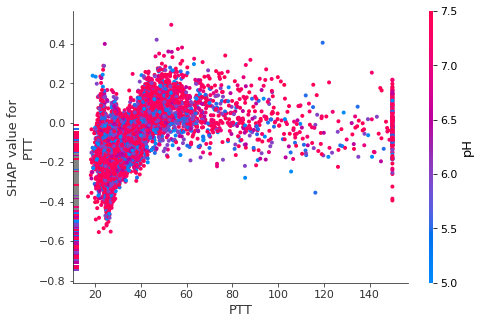

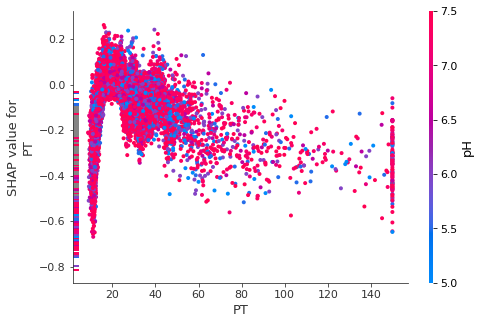

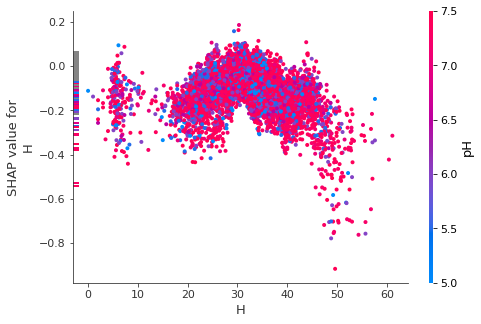

In [7]:
shap_values = explainer.shap_values( X_no_cat, check_additivity=False) # Rounding error, ignore check
shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names)

# CatBoost

In [8]:
CB_classifier = CatBoostClassifier(
     cat_features=cat_features_indices,
     verbose=False,
     early_stopping_rounds=50,
)
CB_params = {
        'learning_rate': [0.05, 0.1],
        'depth': [4,5,6,7,8,9],
        'l2_leaf_reg': [1, 3, 5, 7, 8],
        'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))

} 
# Note Attention: (ignore, affects speed(not result quality))
# Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
model = strat_cv_it(CB_classifier ,CB_params,True,25)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 20.5min finished


0.8500665223253655

{'scale_pos_weight': 11, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'depth': 4}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      118.332442      6.875149         0.877652        0.025597   
1       35.871040      2.441750         0.692481        0.065320   
2       36.671232      0.546370         0.772932        0.057055   
3      110.709833      0.252943         0.903251        0.011056   
4      111.899336      3.132452         1.020603        0.107454   
5       28.495111      0.609803         0.713757        0.043590   
6       29.331202      0.503028         0.660566        0.011410   
7       35.691187      0.260406         0.822466        0.104440   
8       23.249804      0.787588         0.752321        0.194679   
9      117.525600      1.907180         0.862692        0.114083   
10      49.182429      0.475068         0.827785        0.082632   
11      23.439961      1.066824         0.867347        0.062678   
12      28.112462      0.320426         0.715753        0.075416   
13     111.980101      0.958594         0.884966        0.078303   
14      51.044448      2.882072         0.715419        0.083285   
15      52.061726      2.422849         0.816150        0.144068   
16      23.235175      0.564948         0.756310        0.027858   
17      38.300208      1.503930         0.757307        0.051664   
18      79.166223      1.060262         0.927186        0.114540   
19     125.663834      1.853728         1.034898        0.077751   
20     118.595072      0.717795         0.964420        0.053417   
21      25.025386      1.895015         0.722401        0.022172   
22      76.060525      1.320029         0.872001        0.105956   
23      35.579153      1.511710         0.624662        0.023634   
24      58.388801      4.418395         0.385303        0.182540   

   param_scale_pos_weight param_learning_rate param_l2_leaf_reg param_depth  \
0                      12                0.05                 3           9   
1                      21                 0.1                 8           6   
2                      22                 0.1                 1           6   
3                      21                 0.1                 5           9   
4                      19                 0.1                 7           9   
5                      13                0.05                 7           5   
6                      15                 0.1                 3           5   
7                      22                0.05                 1           6   
8                      14                 0.1                 5           4   
9                      22                0.05                 5           9   
10                      8                0.05                 7           7   
11                     11                0.05                 5           4   
12                     18                 0.1                 3           5   
13                     19                 0.1                 8           9   
14                     14                0.05                 7           7   
15                     22                 0.1                 3           7   
16                     22                 0.1                 1           4   
17                      8                 0.1                 8           6   
18                      9                 0.1                 8           8   
19                     20                0.05                 7           9   
20                      9                 0.1                 7           9   
21                     16                 0.1                 7           4   
22                      8                0.05                 7           8   
23                     14                 0.1                 1           6   
24                      8                 0.1                 5           8   

                                               params  split0_test_score  \
0   {'scale_pos_weight': 12, 'learning_rate': 0.05...           0.853348   
1   {'scale_pos_weight': 21,

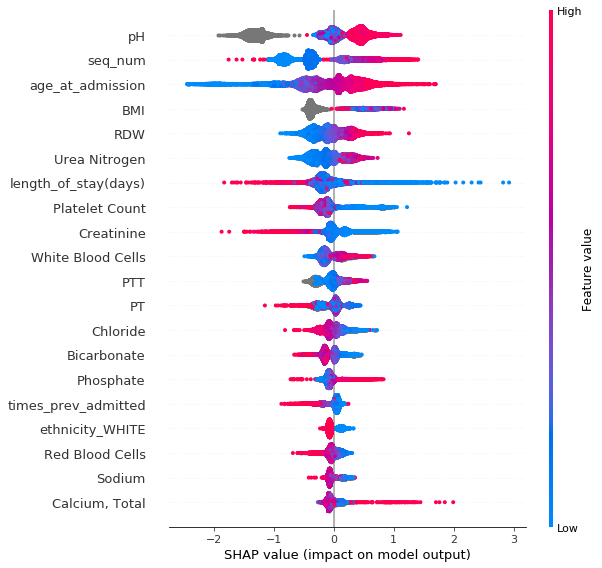

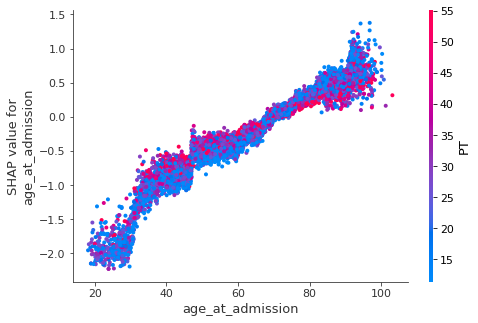

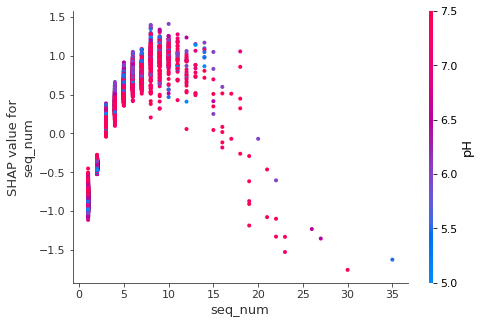

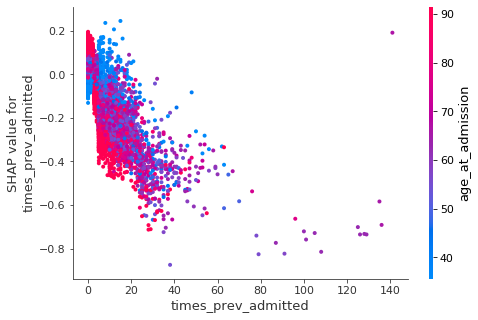

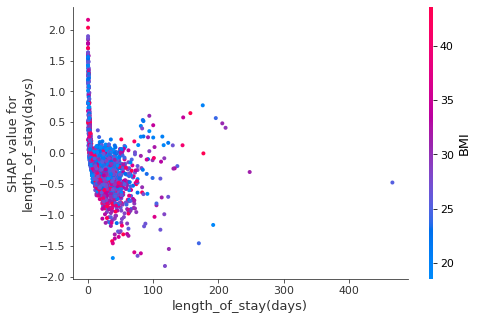

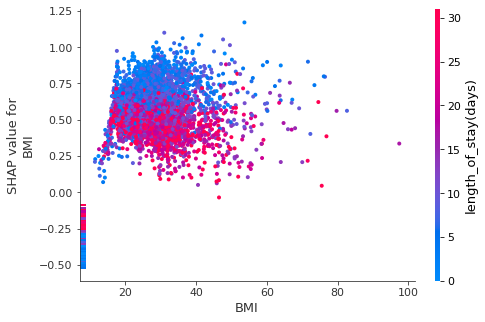

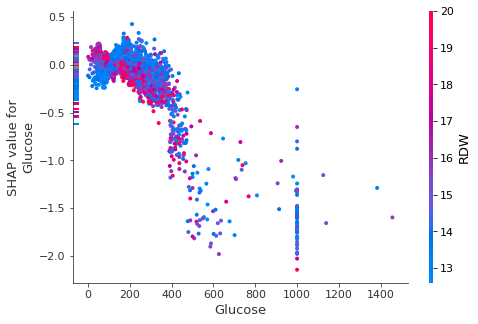

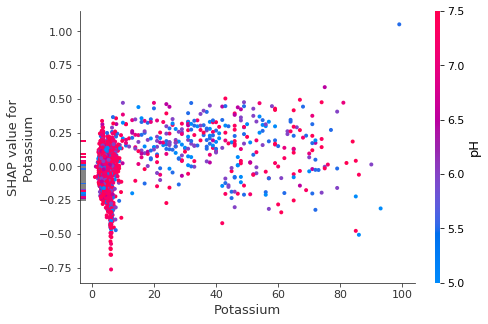

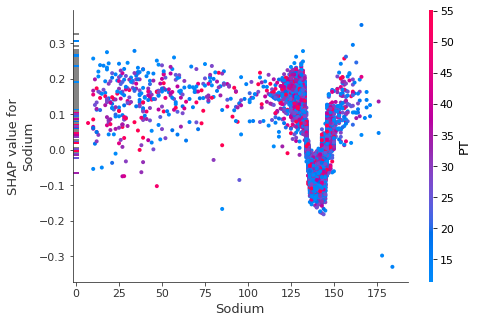

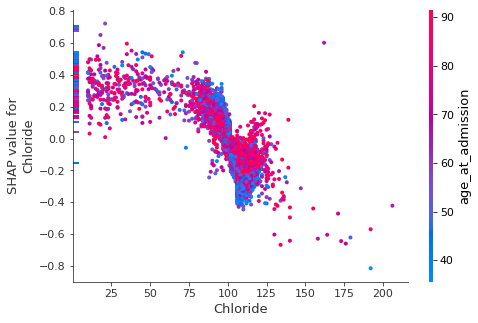

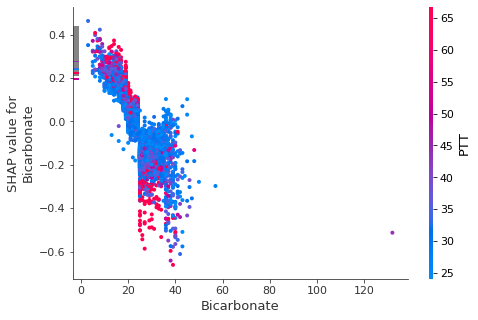

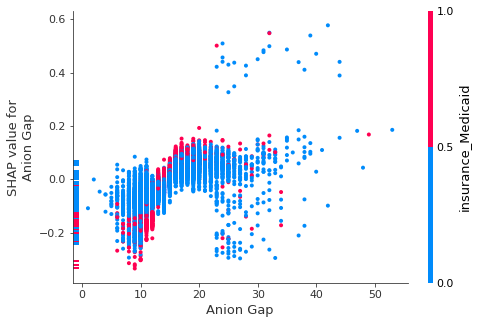

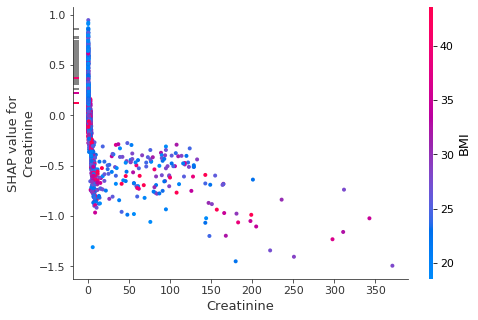

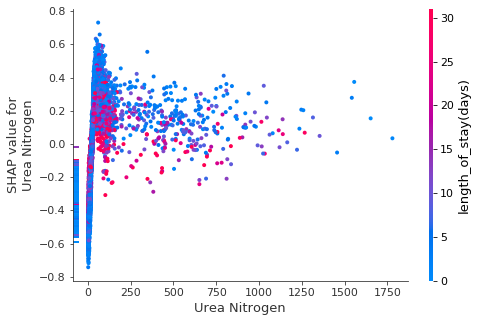

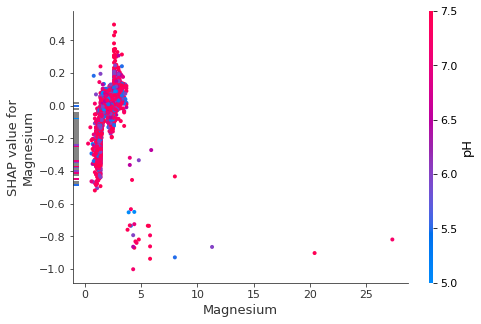

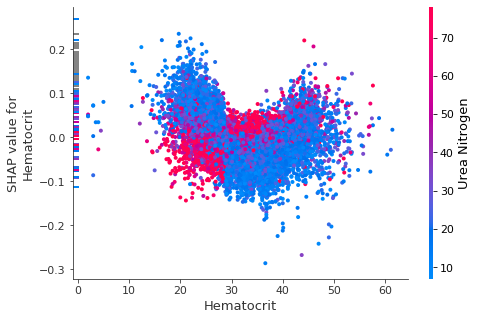

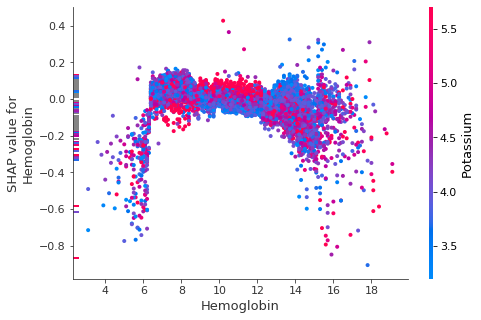

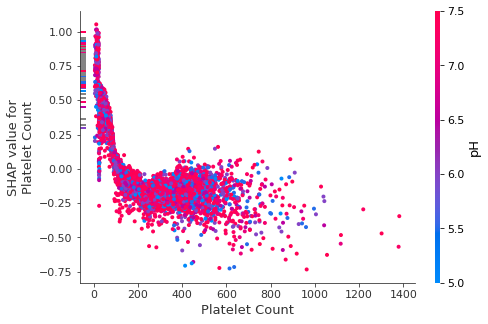

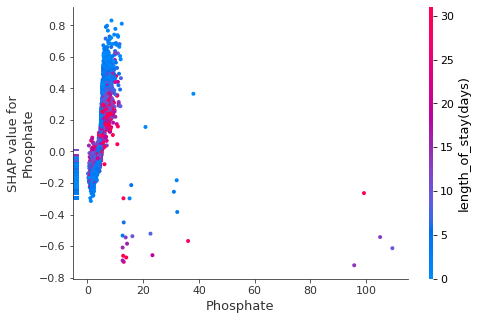

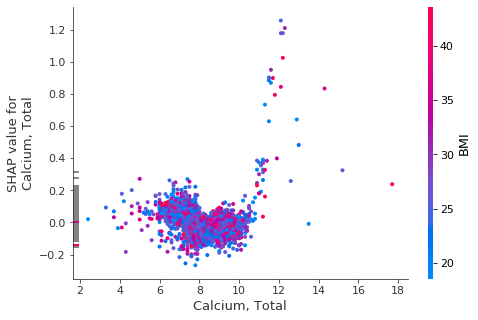

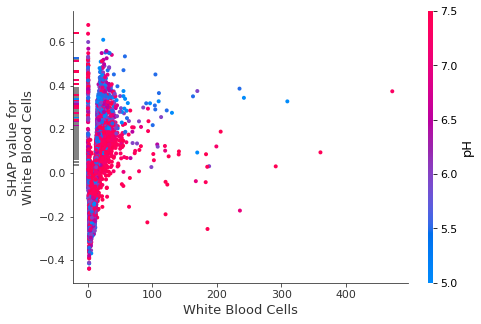

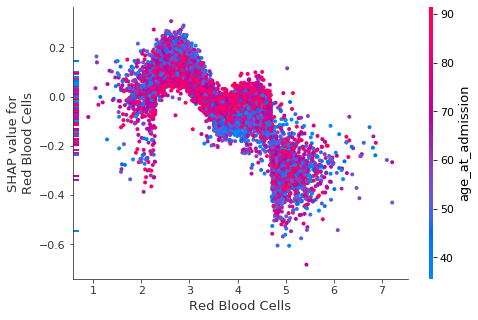

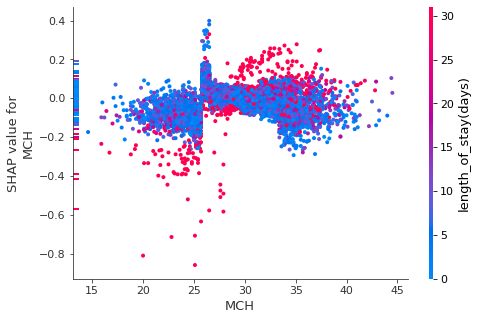

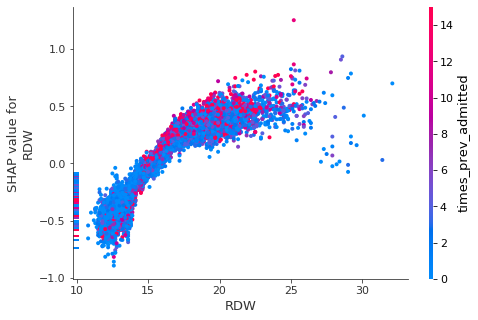

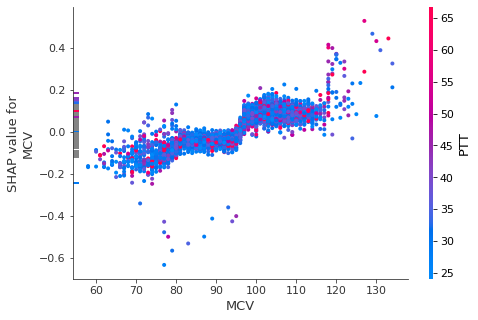

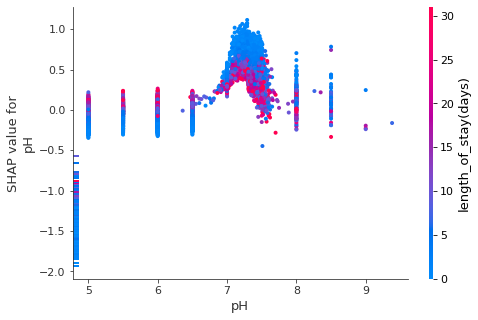

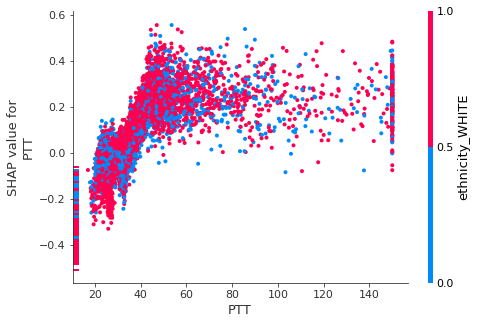

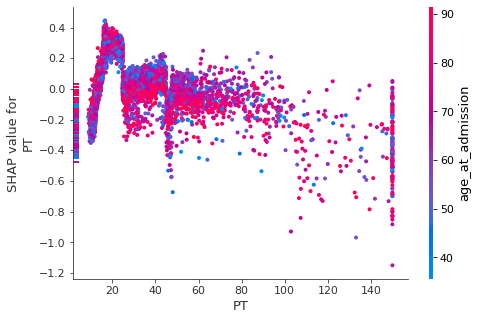

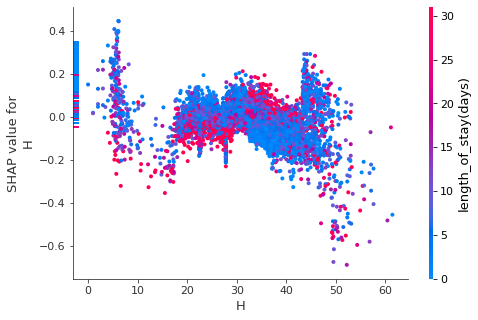

In [9]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values, dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values ,dataset_no_target ,feature_names=feature_names)

# LightGBM

In [10]:
LGB_classifier = lgb.LGBMClassifier()
LGB_params = {
             'num_leaves': [1,5,8,10,15,20,35,40], 
             'min_child_samples': [1,5,10,20,50,100,200,300,400,500], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': [0.2,0,4,0.5, 0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))

}
model = strat_cv_it(LGB_classifier ,LGB_params,True,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.0min finished


0.8559281713900323

{'subsample': 1.0,
 'scale_pos_weight': 11,
 'reg_lambda': 5,
 'reg_alpha': 2,
 'num_leaves': 8,
 'min_child_weight': 100.0,
 'min_child_samples': 200,
 'colsample_bytree': 0.8}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.052214  4.706403e-04         0.000000    0.000000e+00   
1        0.207778  2.049486e-03         0.028929    9.561216e-06   
2        0.276254  5.092639e-03         0.061502    2.487800e-03   
3        0.050864  5.150430e-07         0.000000    0.000000e+00   
4        0.371338  7.564283e-03         0.070146    1.880255e-03   
5        0.305842  2.355742e-03         0.060505    1.244028e-03   
6        0.688491  6.002450e-03         0.107712    8.142961e-04   
7        0.269945  4.847594e-04         0.060166    4.750951e-04   
8        0.052188  1.245974e-03         0.000000    0.000000e+00   
9        0.051529  4.701907e-04         0.000000    0.000000e+00   
10       0.441153  3.082652e-03         0.069149    1.244240e-03   
11       0.052187  9.503271e-04         0.000000    0.000000e+00   
12       0.282930  3.832878e-03         0.056835    8.138635e-04   
13       0.493026  1.892321e-03         0.079450    1.688071e-03   
14       0.450779  6.139977e-03         0.075805    1.405652e-03   
15       0.051848  8.059412e-04         0.000000    0.000000e+00   
16       0.303515  1.688155e-03         0.060179    1.252782e-03   
17       0.385296  2.040413e-03         0.092420    1.244049e-03   
18       0.365363  4.099693e-03         0.070146    9.400995e-04   
19       0.052852  1.406327e-03         0.000000    0.000000e+00   
20       0.051528  4.699655e-04         0.000000    0.000000e+00   
21       0.464763  9.863149e-03         0.094414    2.487822e-03   
22       1.023254  4.300987e-03         0.097745    8.223874e-04   
23       0.050857  9.667637e-06         0.000000    0.000000e+00   
24       0.052197  2.052590e-03         0.000000    0.000000e+00   
25       0.426525  4.701565e-03         0.078138    1.245934e-03   
26       0.262644  1.245038e-03         0.058843    8.778064e-07   
27       0.487356  1.462647e-02         0.085445    3.076920e-03   
28       0.052187  9.358618e-04         0.000000    0.000000e+00   
29       0.286906  1.234685e-03         0.057526    1.242149e-03   
30       0.874321  3.507440e-02         0.123012    3.671446e-03   
31       0.249659  2.497191e-03         0.057180    4.700217e-04   
32       0.052187  9.360346e-04         0.000000    0.000000e+00   
33       0.324451  4.475662e-03         0.068823    8.054556e-04   
34       0.051529  4.704713e-04         0.000000    0.000000e+00   
35       0.050531  4.703027e-04         0.000000    0.000000e+00   
36       0.420209  2.617414e-03         0.086775    8.225833e-04   
37       0.050866  8.122547e-04         0.000000    0.000000e+00   
38       0.371672  1.695264e-03         0.073803    3.893359e-07   
39       0.051188  4.574905e-04         0.000000    0.000000e+00   
40       1.120668  4.484716e-03         0.106057    4.657068e-04   
41       0.339767  1.886952e-03         0.059498    1.252141e-03   
42       0.458114  6.106691e-03         0.075791    8.225833e-04   
43       0.053520  3.759218e-03         0.000000    0.000000e+00   
44       0.091416  5.177887e-02         0.000000    0.000000e+00   
45       0.058510  5.422011e-03         0.000000    0.000000e+00   
46       0.056515  3.389733e-03         0.000000    0.000000e+00   
47       0.302869  1.345679e-02         0.058505    4.667851e-04   
48       0.064826  1.140108e-02         0.000000    0.000000e+00   
49       0.648597  5.005002e-02         0.117027    1.810075e-02   

   param_subsample param_scale_pos_weight param_reg_lambda param_reg_alpha  \
0                0                     19               10              50   
1              0.2                     20               10             0.1   
2              0.8                     20               50               0   
3                1                     20              0.1              50   
4              0.8                     22                0               0   
5              0.8                     19               20         

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


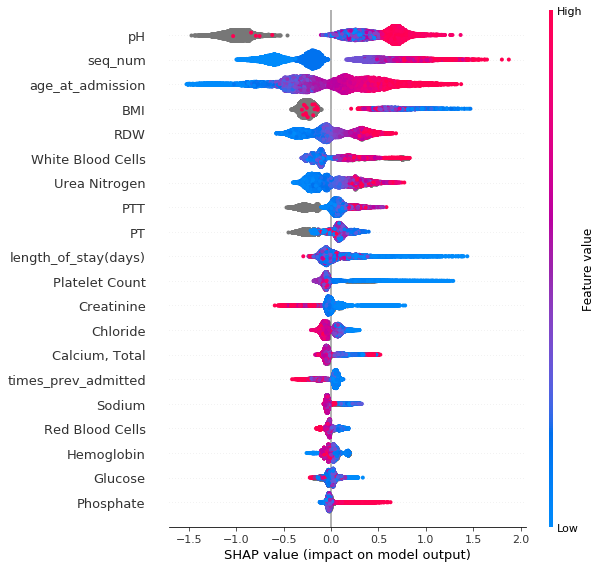

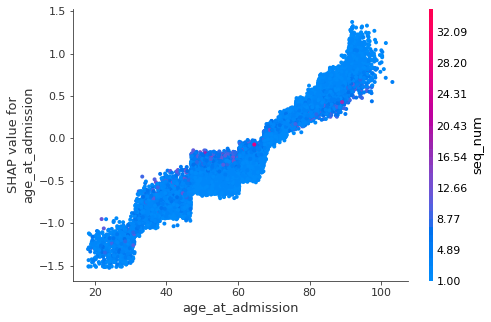

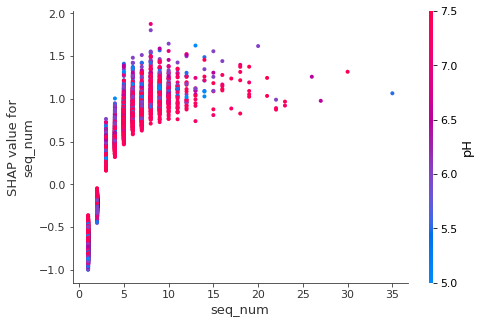

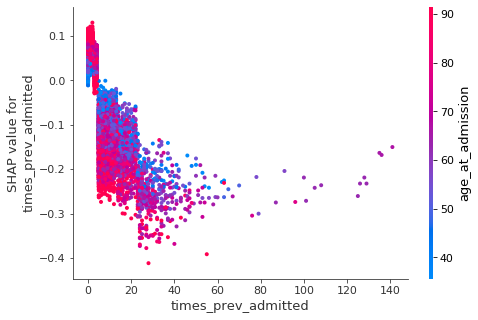

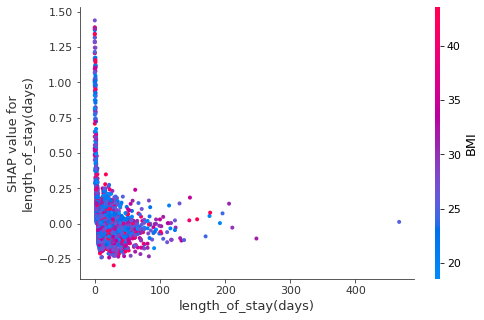

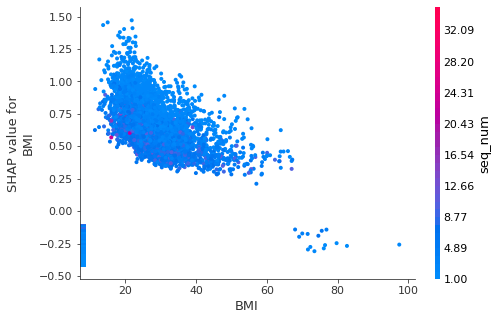

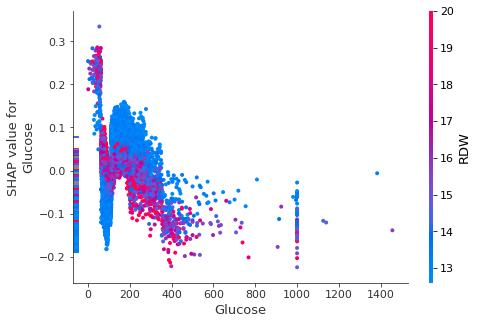

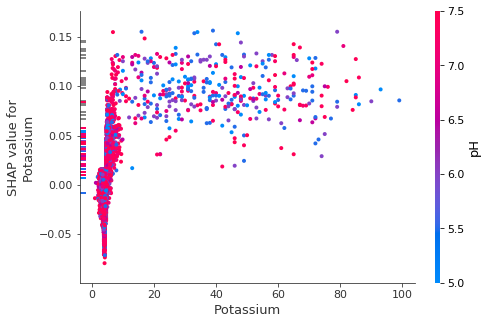

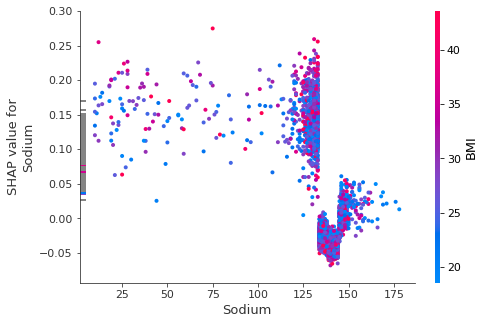

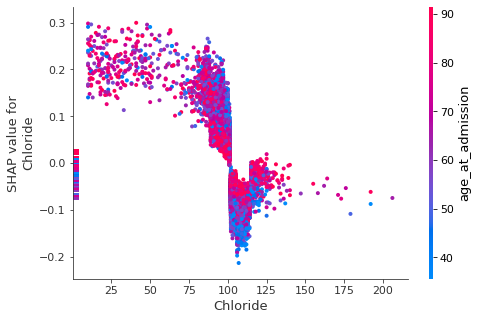

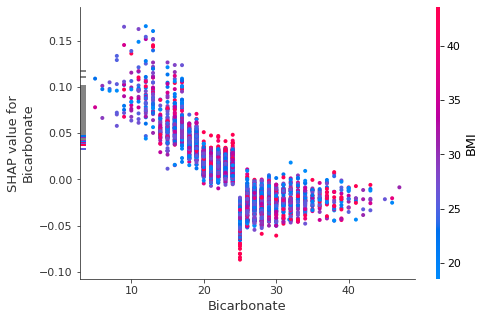

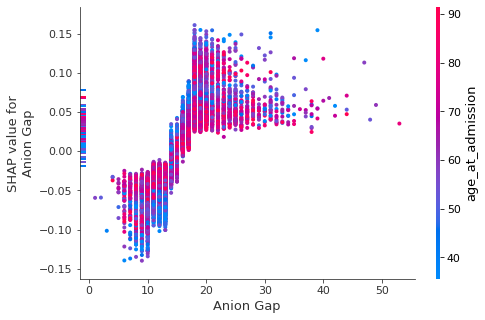

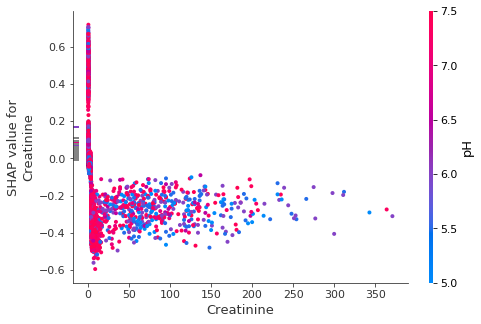

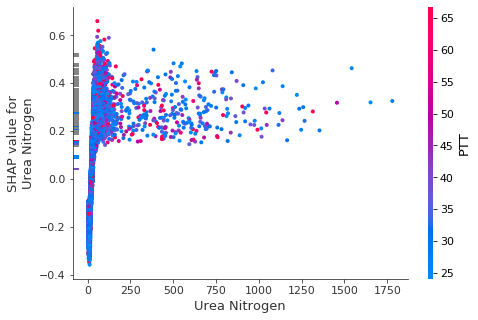

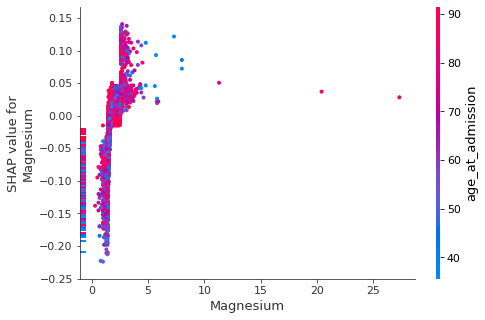

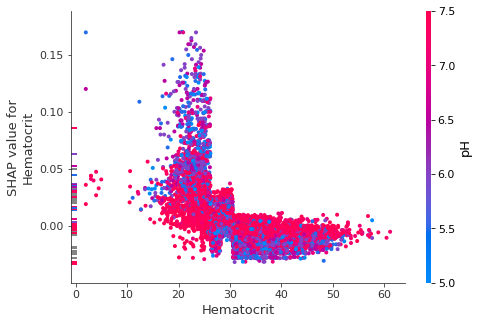

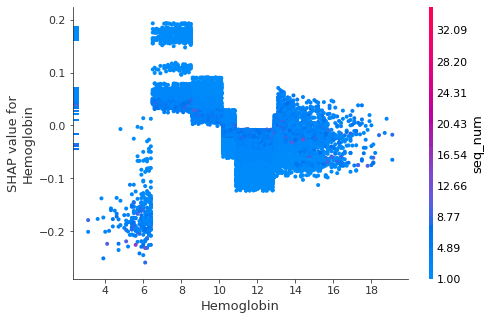

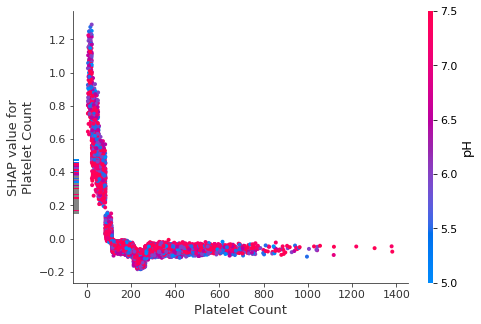

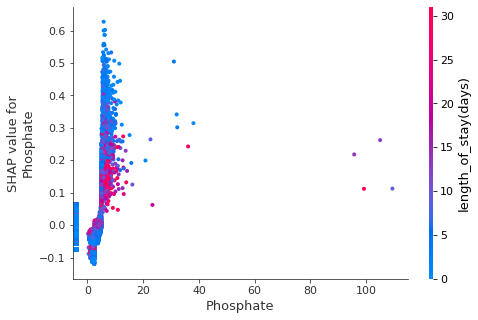

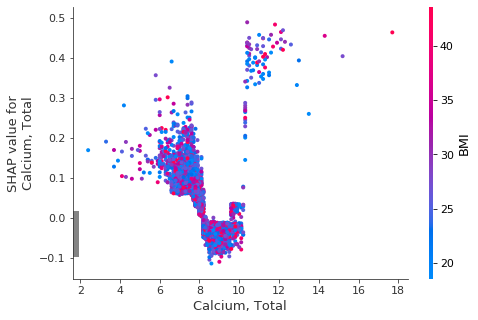

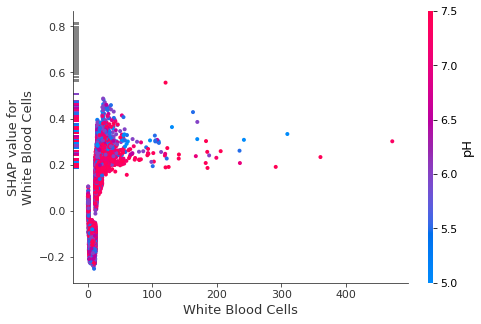

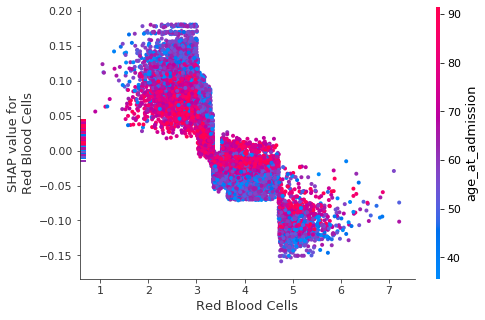

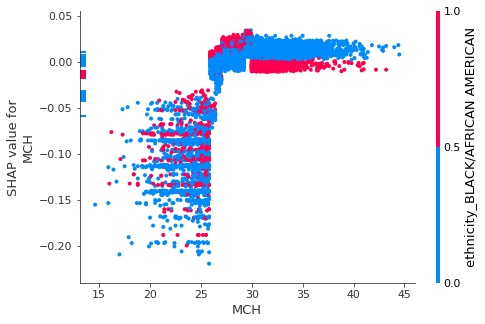

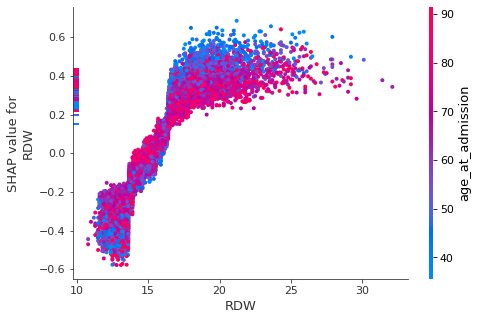

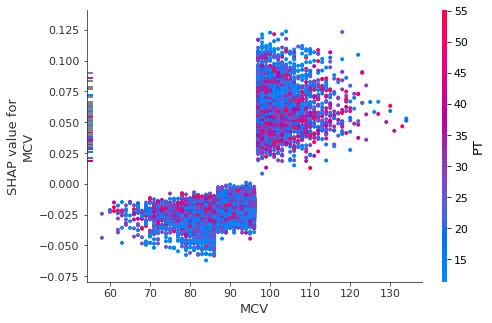

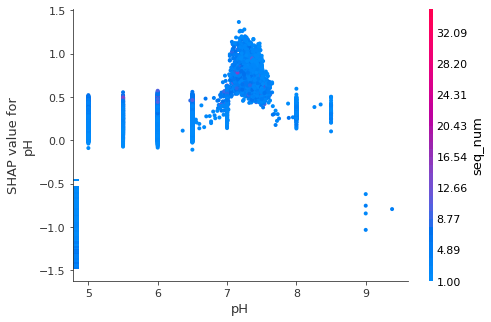

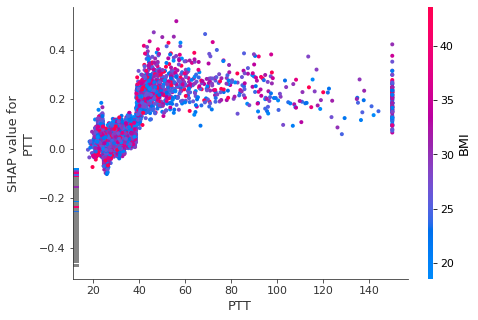

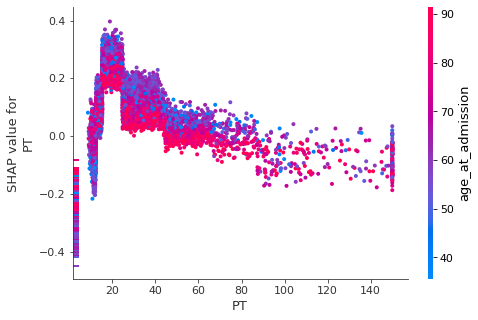

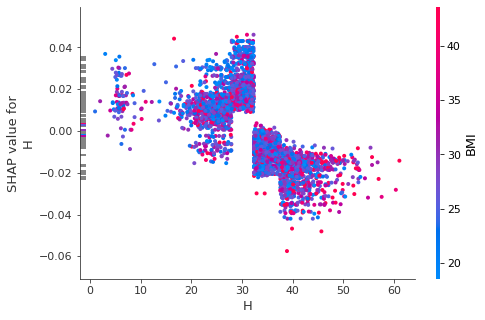

In [11]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values[1], dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1] ,dataset_no_target ,feature_names=feature_names)